In [ ]:
#import the drive to the collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
movie_reviews = pd.read_csv('/content/drive/My Drive/movies-review/IMDB Dataset.csv')
movie_reviews.isnull().values.any()
movie_reviews.shape
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

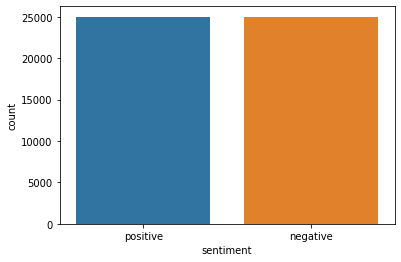

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
   
    # Remove punctuations and numbers
    
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
movie_reviews["review"][3],X[3]

("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you 

In [ ]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
#sent = tokenizer.texts_to_sequences(sentence)

In [ ]:
sentence=[]
sentence.append('hello hi what')
sent = tokenizer.texts_to_sequences(sentence)
print(sent)

[[4936, 4853, 43]]


In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 300


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/movies-review/glove/glove.42B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras import regularizers

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
#model.add(Flatten())
model.add(LSTM(32, return_sequences=True,kernel_regularizer=None,recurrent_regularizer=None))
model.add(Dense(5, activation='relu'))
#model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 300)          27764100  
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 32)           42624     
_________________________________________________________________
dense (Dense)                (None, 300, 5)            165       
_________________________________________________________________
dense_1 (Dense)              (None, 300, 1)            6         
Total params: 27,806,895
Trainable params: 42,795
Non-trainable params: 27,764,100
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 82s 330ms/step - loss: 0.6852 - acc: 0.5285 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 2/6
250/250 [==============================] - 82s 329ms/step - loss: 0.6894 - acc: 0.5153 - val_loss: 0.6917 - val_acc: 0.5236
Epoch 3/6
250/250 [==============================] - 83s 333ms/step - loss: 0.6417 - acc: 0.6479 - val_loss: 0.6769 - val_acc: 0.5580
Epoch 4/6
250/250 [==============================] - 83s 333ms/step - loss: 0.6147 - acc: 0.6821 - val_loss: 0.5421 - val_acc: 0.7794
Epoch 5/6
250/250 [==============================] - 83s 332ms/step - loss: 0.5671 - acc: 0.7556 - val_loss: 0.5276 - val_acc: 0.7765
Epoch 6/6
250/250 [==============================] - 83s 331ms/step - loss: 0.5213 - acc: 0.7753 - val_loss: 0.5080 - val_acc: 0.7897


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 12s 39ms/step - loss: 0.5119 - acc: 0.7871


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5119065046310425
Test Accuracy: 0.7871427536010742


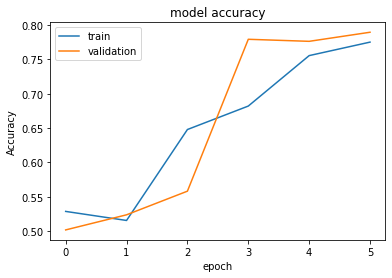

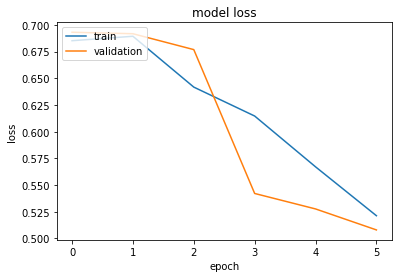

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
p =input("Enter your sentence: ")
p=preprocess_text(p)
print(p)
sentence=[]
sentence.append(p)
sent = tokenizer.texts_to_sequences(sentence)
print(sent)
sent = pad_sequences(sent, padding='post', maxlen=maxlen)

if (model.predict(sent)[0][0] > 0.5).astype("int32"):
  print("p")
else:
  print("n")

Enter your sentence: not good movie
not good movie
[[19, 45, 12]]
p
